Major Project final


### Custom Datasets and DataLoaders

In [1]:
import os, torch, shutil, numpy as np, pandas as pd
from glob import glob; from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(2024)

class CustomDataset(Dataset):
    
    def __init__(self, root, transformations = None):
        
        self.transformations = transformations
        meta_data = pd.read_csv(f"{root}/2-Groundtruths/HRDC Hypertensive Classification Training Labels.csv")
        im_names = list(meta_data["Image"])
        gt_names = list(meta_data["Hypertensive"])
        self.meta_data = {}
        
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(im_names):
            class_name = gt_names[idx]
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1
            self.meta_data[f"{root}/1-Images/1-Training Set/{im_path}"] = class_name
        
    def __len__(self): return len(self.meta_data)

    def __getitem__(self, idx):
        
        im_path = list(self.meta_data.keys())[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.meta_data[im_path]
        
        if self.transformations is not None: im = self.transformations(im)
        
        return im, gt
    
def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):
    
    ds = CustomDataset(root = root, transformations = transformations)
    
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)
    
    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])
    
    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)
    
    return tr_dl, val_dl, ts_dl, ds.cls_names

root = "/kaggle/input/hypertension-and-hypertensive-retinopathy-dataset/1-Hypertensive Classification/1-Hypertensive Classification"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

20
2
37
{0: 0, 1: 1}


### Data Visualization

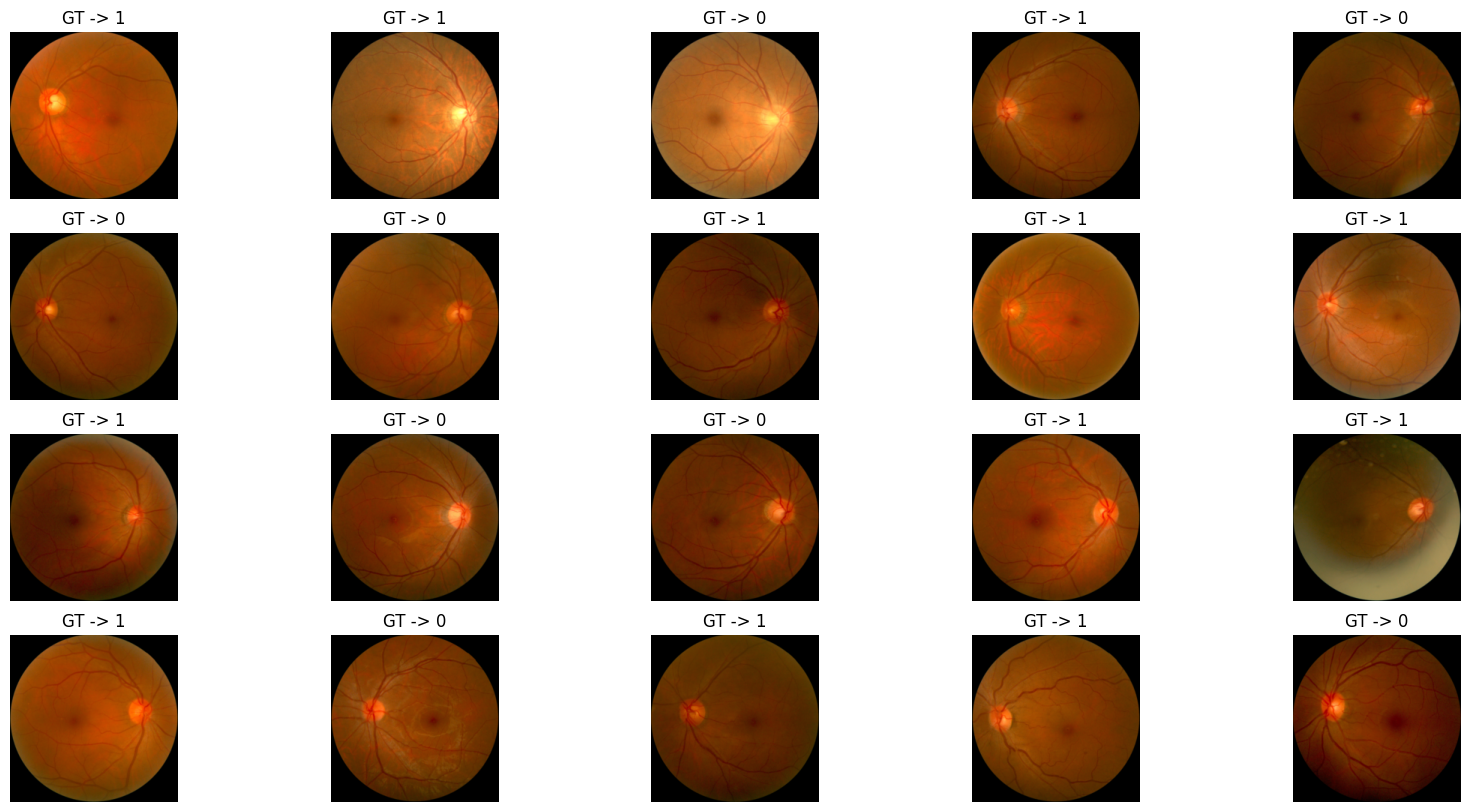

In [2]:
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):
    
    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])
    
    invTrans = gray_tfs if t_type == "gray" else rgb_tfs 
    
    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):
        
        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")
            
visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

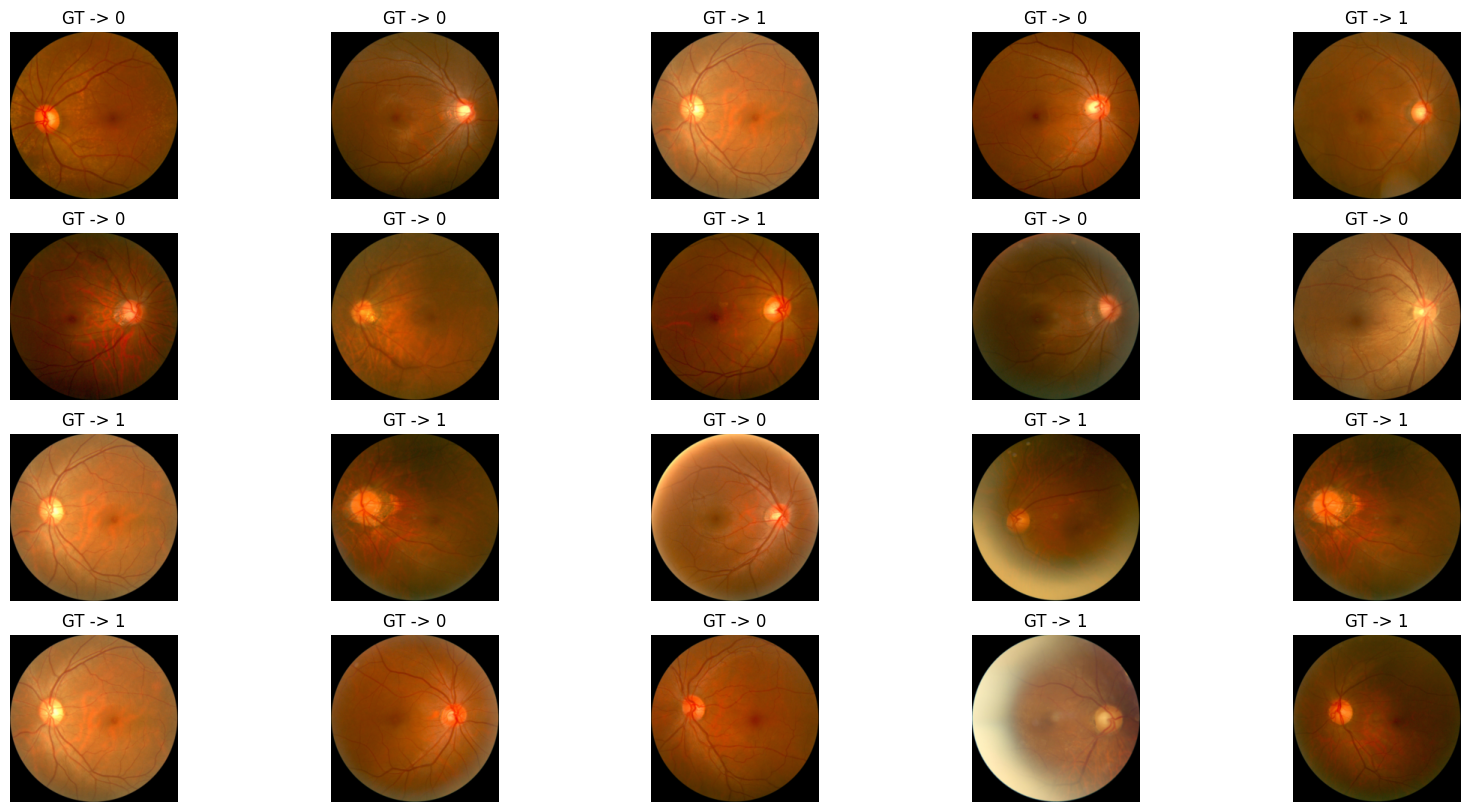

In [3]:
visualize(val_dl.dataset, 20, 4, "rgb", list(classes.keys()))

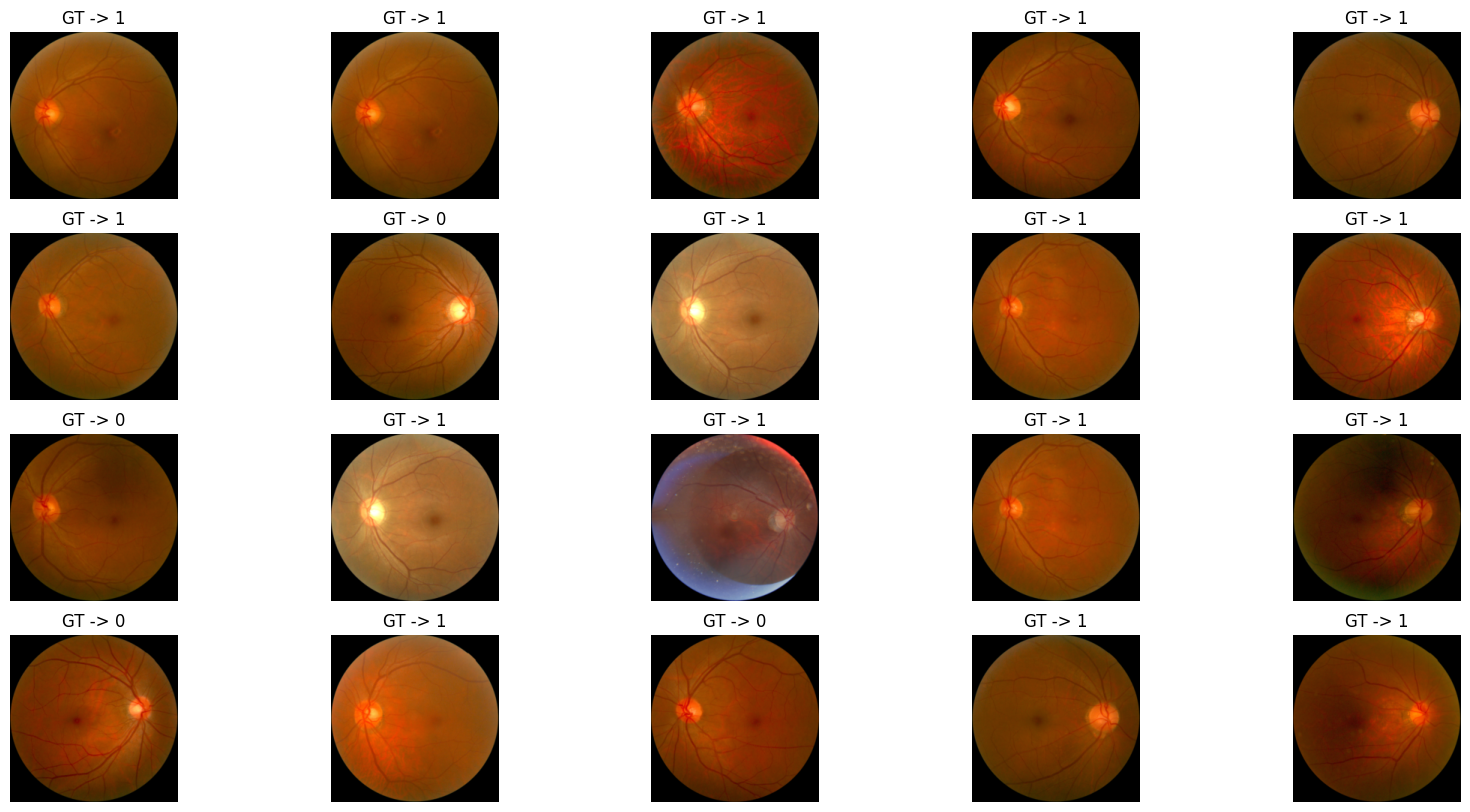

In [4]:
visualize(ts_dl.dataset, 20, 4, "rgb", list(classes.keys()))

### Data Analysis

/tmp/ipykernel_25/1844673426.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cls_names, rotation = 60)


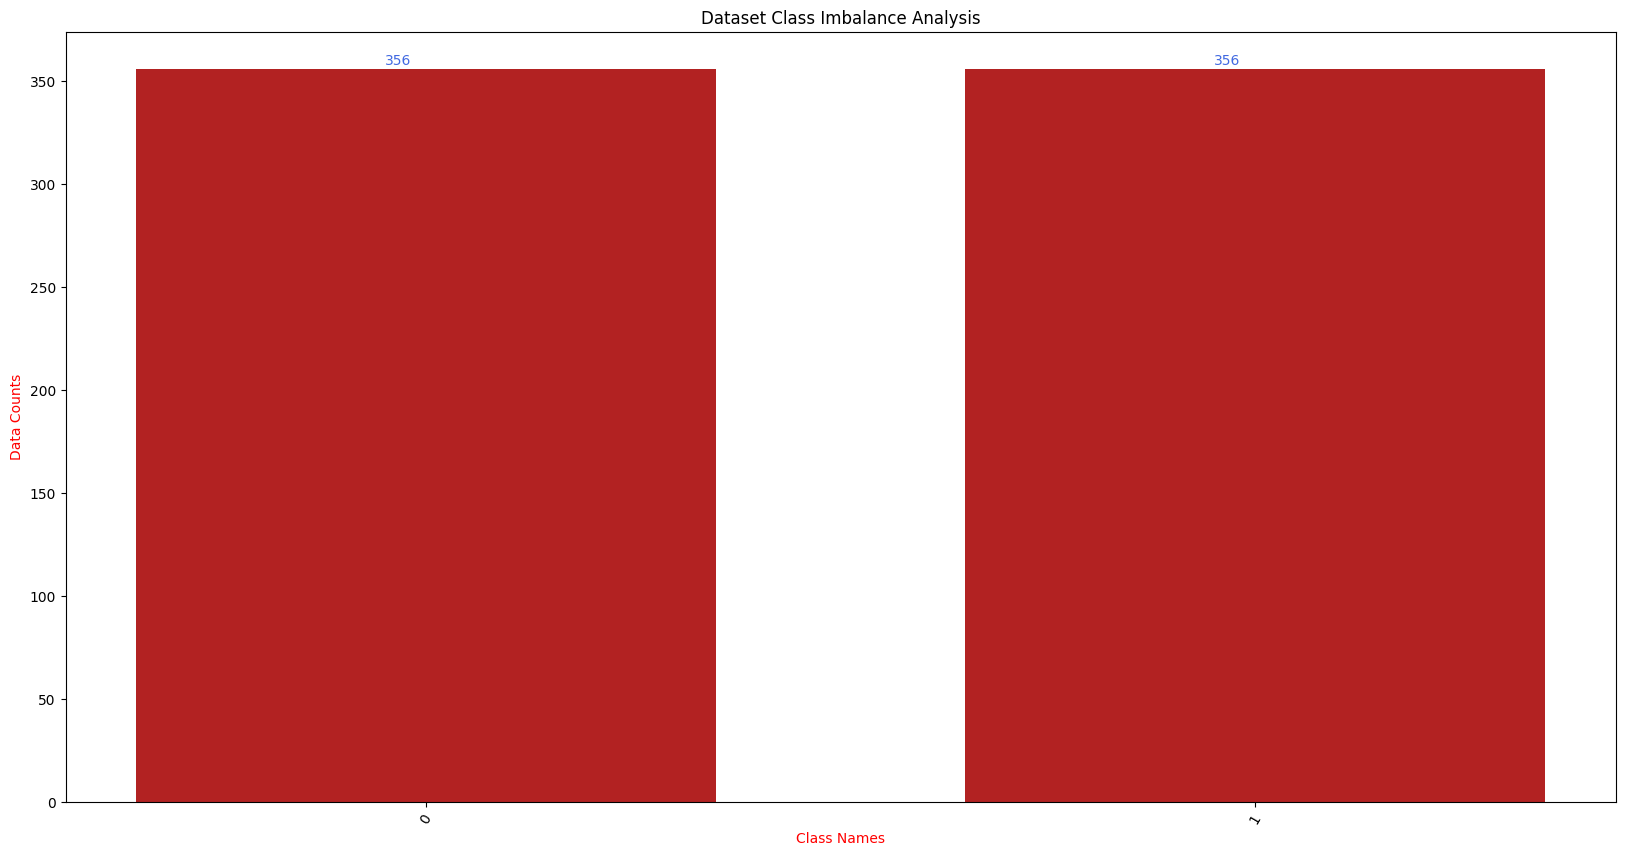

In [5]:
def data_analysis(root, transformations):
    
    ds = CustomDataset(root = root, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())
    
    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")
    
data_analysis(root = root, transformations = tfs)

### AI Model Train and Validation

In [6]:
import timm, torchmetrics
from tqdm import tqdm
m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))  

def train_setup(m): return m.to("cuda").eval(), 10, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "food", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)
    
for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc  / len(val_dl.dataset)
        val_f1_to_track   = val_epoch_f1   / len(val_dl)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track); val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")
            
        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

model.safetensors:   0%|          | 0.00/39.2M [00:00<?, ?B/s]

Start training...


20it [00:07,  2.58it/s]


1-epoch train process is completed!
1-epoch train loss          -> 3.063
1-epoch train accuracy      -> 0.516
1-epoch train f1-score      -> 0.516
1-epoch validation process is completed!
1-epoch validation loss     -> 0.688
1-epoch validation accuracy -> 0.743
1-epoch validation f1-score -> 0.557


20it [00:06,  3.18it/s]


2-epoch train process is completed!
2-epoch train loss          -> 0.687
2-epoch train accuracy      -> 0.573
2-epoch train f1-score      -> 0.573
2-epoch validation process is completed!
2-epoch validation loss     -> 0.771
2-epoch validation accuracy -> 0.514
2-epoch validation f1-score -> 0.432
Loss value did not decrease for 1 epochs


20it [00:06,  2.89it/s]


3-epoch train process is completed!
3-epoch train loss          -> 0.687
3-epoch train accuracy      -> 0.533
3-epoch train f1-score      -> 0.533
3-epoch validation process is completed!
3-epoch validation loss     -> 0.641
3-epoch validation accuracy -> 0.657
3-epoch validation f1-score -> 0.812


20it [00:06,  3.08it/s]


4-epoch train process is completed!
4-epoch train loss          -> 0.666
4-epoch train accuracy      -> 0.633
4-epoch train f1-score      -> 0.633
4-epoch validation process is completed!
4-epoch validation loss     -> 0.662
4-epoch validation accuracy -> 0.743
4-epoch validation f1-score -> 0.557
Loss value did not decrease for 2 epochs


20it [00:06,  3.14it/s]


5-epoch train process is completed!
5-epoch train loss          -> 0.651
5-epoch train accuracy      -> 0.637
5-epoch train f1-score      -> 0.637
5-epoch validation process is completed!
5-epoch validation loss     -> 0.705
5-epoch validation accuracy -> 0.686
5-epoch validation f1-score -> 0.526
Loss value did not decrease for 3 epochs


20it [00:06,  3.09it/s]


6-epoch train process is completed!
6-epoch train loss          -> 0.689
6-epoch train accuracy      -> 0.530
6-epoch train f1-score      -> 0.530
6-epoch validation process is completed!
6-epoch validation loss     -> 0.654
6-epoch validation accuracy -> 0.771
6-epoch validation f1-score -> 0.724
Loss value did not decrease for 4 epochs


20it [00:06,  3.04it/s]


7-epoch train process is completed!
7-epoch train loss          -> 0.624
7-epoch train accuracy      -> 0.683
7-epoch train f1-score      -> 0.683
7-epoch validation process is completed!
7-epoch validation loss     -> 0.551
7-epoch validation accuracy -> 0.743
7-epoch validation f1-score -> 0.557


20it [00:06,  3.09it/s]


8-epoch train process is completed!
8-epoch train loss          -> 0.553
8-epoch train accuracy      -> 0.744
8-epoch train f1-score      -> 0.744
8-epoch validation process is completed!
8-epoch validation loss     -> 0.603
8-epoch validation accuracy -> 0.771
8-epoch validation f1-score -> 0.573
Loss value did not decrease for 5 epochs
Stop training since loss value did not decrease for 5 epochs.


### Learning Curves

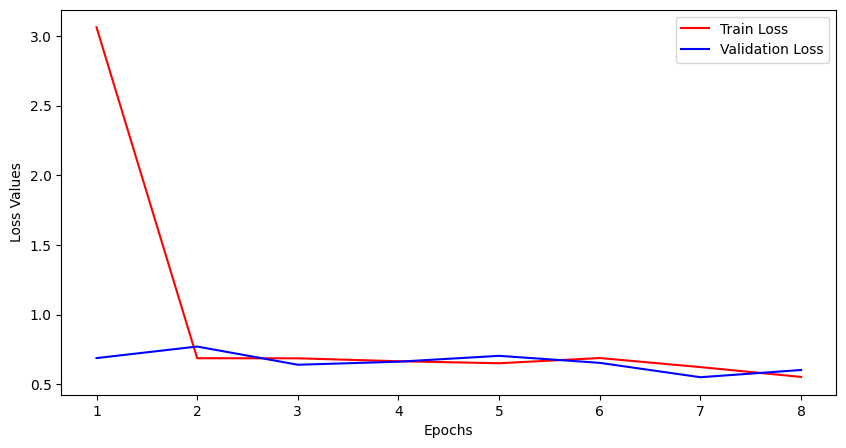

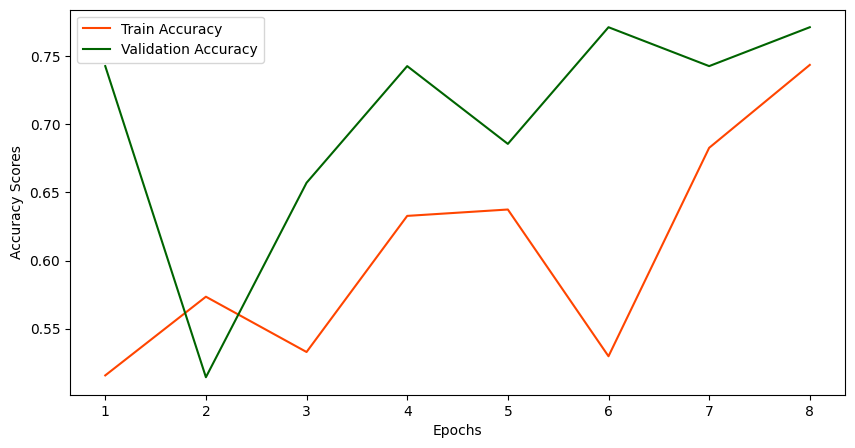

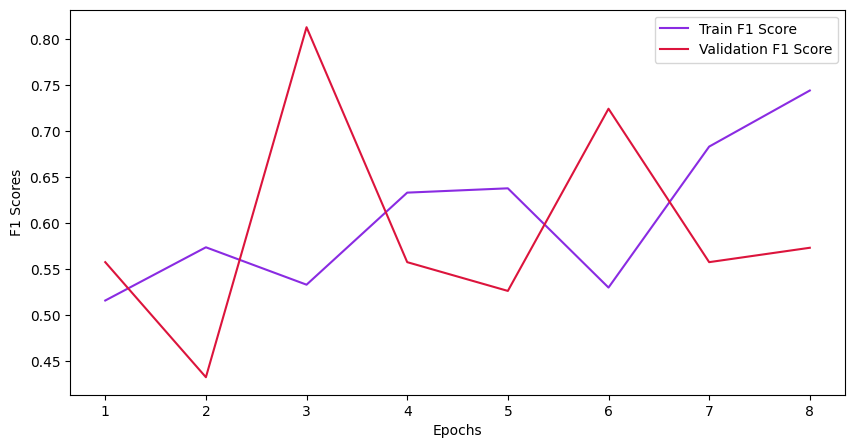

In [7]:
class PlotLearningCurves:
    
    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):
        
        self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s
        
    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):
        
        plt.plot(array_1, label = label_1, c = color_1); plt.plot(array_2, label = label_2, c = color_2)
        
    def create_figure(self): plt.figure(figsize = (10, 5))
    
    def decorate(self, ylabel, xlabel = "Epochs"): 
        
        plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_accs)), labels = [i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend(); plt.show()      
        
    def visualize(self):
        
        # Figure 1
        self.create_figure()
        self.plot(array_1 = self.tr_losses, array_2 = self.val_losses, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = "red", color_2 = "blue"); self.decorate(ylabel = "Loss Values")
        
        # Figure 2
        self.create_figure()
        self.plot(array_1 = self.tr_accs, array_2 = self.val_accs, label_1 = "Train Accuracy", label_2 = "Validation Accuracy", color_1 = "orangered", color_2 = "darkgreen")
        self.decorate(ylabel = "Accuracy Scores")
        
        # Figure 3
        self.create_figure()
        self.plot(array_1 = [tr_f1.cpu() for tr_f1 in self.tr_f1s], array_2 = [vl_f1.cpu() for vl_f1 in self.val_f1s], label_1 = "Train F1 Score", label_2 = "Validation F1 Score", color_1 = "blueviolet", color_2 = "crimson"); self.decorate(ylabel = "F1 Scores")
        
PlotLearningCurves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s).visualize()

### Inference and AI Model Performance Analysis with GradCAM

37it [00:00, 40.02it/s]


Accuracy of the model on the test data -> 0.541


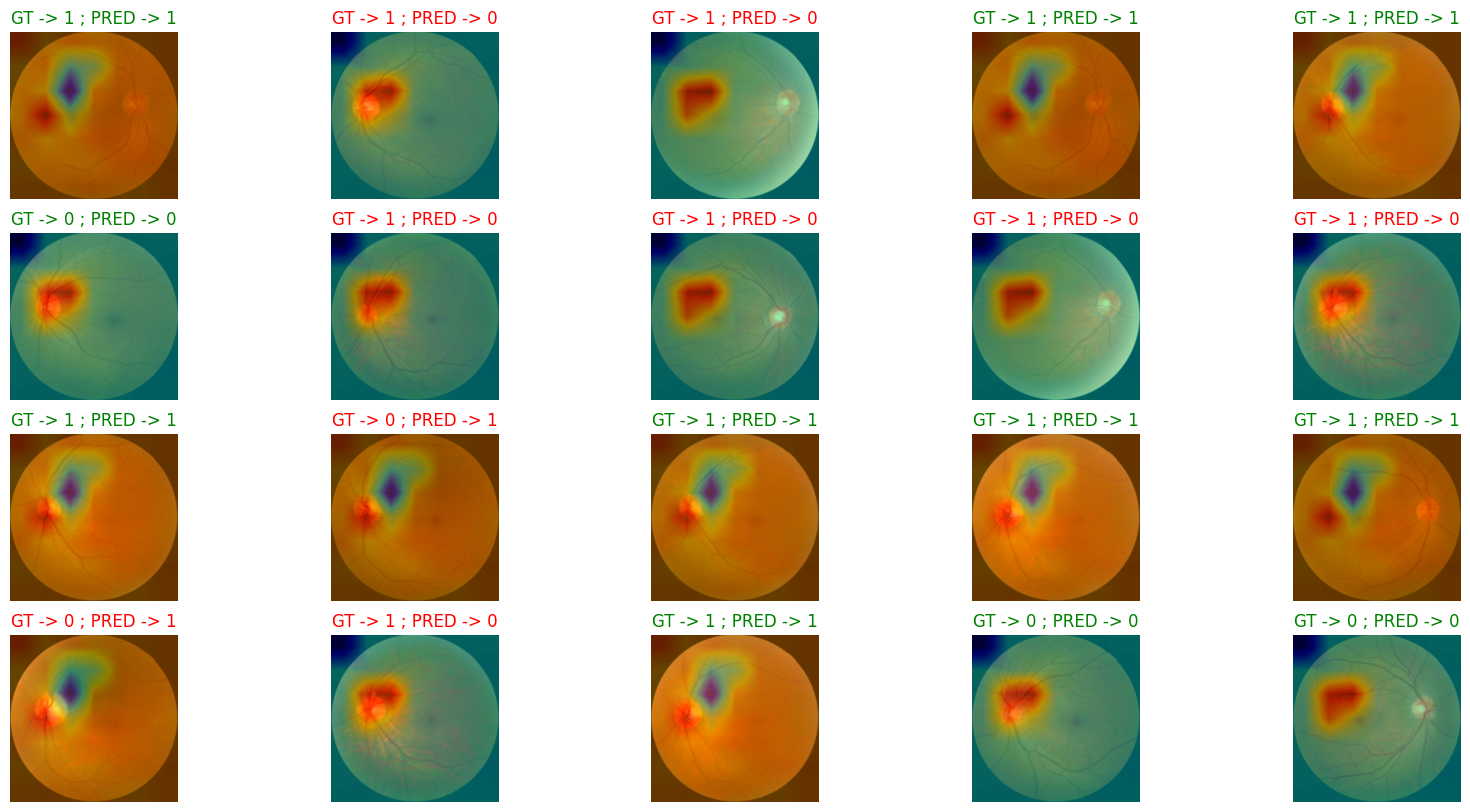

In [8]:
import cv2
class SaveFeatures():
    
    """ Extract pretrained activations"""
    features = None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

def getCAM(conv_fs, linear_weights, class_idx):
    
    bs, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0,:, :, ].reshape((chs, h * w)))
    cam = cam.reshape(h, w)
    
    return (cam - np.min(cam)) / np.max(cam)

def inference(model, device, test_dl, num_ims, row, final_conv, fc_params, cls_names = None):
    
    weight, acc = np.squeeze(fc_params[0].cpu().data.numpy()), 0
    activated_features = SaveFeatures(final_conv)
    preds, images, lbls = [], [], []
    for idx, batch in tqdm(enumerate(test_dl)):
        im, gt = to_device(batch, device)
        pred_class = torch.argmax(model(im), dim = 1)
        acc += (pred_class == gt).sum().item()
        images.append(im)
        preds.append(pred_class.item())
        lbls.append(gt.item())
    
    print(f"Accuracy of the model on the test data -> {(acc / len(test_dl.dataset)):.3f}")
    
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]
    
    for idx, indeks in enumerate(indekslar):
        
        im = images[indeks].squeeze()
        pred_idx = preds[indeks]
        heatmap = getCAM(activated_features.features, weight, pred_idx)
        
        # Start plot
        plt.subplot(row, num_ims // row, idx + 1)
        plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")
        plt.imshow(cv2.resize(heatmap, (im_size, im_size), interpolation=cv2.INTER_LINEAR), alpha=0.4, cmap='jet'); plt.axis("off")
        
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(lbls[indeks])]} ; PRED -> {cls_names[int(preds[indeks])]}", color=("green" if {cls_names[int(lbls[indeks])]} == {cls_names[int(preds[indeks])]} else "red"))
        else: plt.title(f"GT -> {gt} ; PRED -> {pred}")

m.load_state_dict(torch.load(f"{save_dir}/{save_prefix}_best_model.pth"))
m.eval()
final_conv, fc_params = m.features[-1], list(m.head.fc.parameters())
inference(model = m.to(device), device = device, test_dl = ts_dl, num_ims = 20, row = 4, cls_names = list(classes.keys()), final_conv = final_conv, fc_params = fc_params)